In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 10
plt.rcParams['axes.grid'] = True
plt.gray()

import numpy as np
import pandas as pd

<Figure size 1080x720 with 0 Axes>

# 6. Linear Regression and Its Cousins

We will dicuss several models here, all of which are akin to linear regression in that each can directly or indirectly be written in the form
$$y_i = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_p x_{ip} + \epsilon_i,$$
where $y_i$ represents the numeric response for the $i$th sample, $\beta_0$ represents the estimated intercept, $\beta_j$ represents the estimated coefficient for the $j$th predictor, $x_{ij}$ represents the value of the $j$th predictor for the $i$th sample, and $\epsilon_i$ represents random error that cannot be explained by the model. In addition to ordinary linear regression, these types of models include partial least square (PLS) and penalized models such as ridge regression, the lasso, and the elastic net.

Each of these models seek to find estimates of the parameters so that the sum of squared errors or a function of the sum of squared errors is minimized. The objectives of the methods find parameter estimates that fall along the spectrum of the bias-variance trade-off. Ordinary linear regression, at one extreme, finds parameter estimates that have minimum bias, where ridge regression, the lasso, and the elastic net find estimates that have lower variance.

A distinct advantage of linear regression models is that they are highly interpretable. Furthermore, relationships among predictors can be further interpreted through the estimated coefficients. Another advantage is that their mathematrical nature enables us to compute standard errors of the coefficients, provided that we make certain assumptions about the distribution of the model residuals.

While linear regression-type models are highly interpretable, they can be limited in their usefulness. First, these models are appropriate when the relationship between the predictors and response falls along a hyperplane. If there is a curvilinear relationship between the predictors and response, then linear regression models can be augmented with additional predictors that are functions of the original predictors in an attempt to capture these relationships.

## 6.1 Case Study: Quantitative Structure-Acitivity Relationship Modeling

The study investigated a set of compounds with corresponding experimental solubility values using complex sets of descriptors. We will use 1,267 compounds (951 training and 316 test by random sampling) and a set of more understandable descriptors:
- Two hundred and eight binary "fingerprints" that indicate the presence or absence of a particular chemical substructure.
- Sixteen count descriptors, such as the number of bonds or the number of bromine atoms.
- Four continuous descriptors, such as molecular weight or surface area.

The training set will be used to tune and estimate models, as well as to determine initial estimates of performance using repeated 10-fold cross-validation. The test set will be used for a final characterization of the model of interest.

In [2]:
# training
trainX = pd.read_csv("../datasets/solubility/solTrainX.csv").drop("Unnamed: 0", axis=1)
trainY = pd.read_csv("../datasets/solubility/solTrainY.csv").drop("Unnamed: 0", axis=1)

# test 
testX = pd.read_csv("../datasets/solubility/solTestX.csv").drop("Unnamed: 0", axis=1)
testY = pd.read_csv("../datasets/solubility/solTestY.csv").drop("Unnamed: 0", axis=1)

In [3]:
trainX.head(5)

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
0,0,1,0,0,1,0,0,1,0,0,...,14,2,0,0,0,0,3,-0.856,25.78,25.78
1,0,1,0,1,1,1,1,1,0,0,...,21,3,1,1,0,0,4,-0.370,52.19,80.43
2,1,1,1,1,1,0,0,1,0,1,...,13,0,2,0,0,0,1,-0.330,37.30,37.30
3,0,0,1,0,0,0,1,0,0,0,...,10,0,0,0,0,0,1,-0.960,0.00,0.00
4,0,0,1,1,1,1,0,0,1,0,...,9,5,0,0,1,1,1,-0.069,53.94,53.94


In [4]:
trainY.head(5)

,0
0,-3.97
1,-3.98
2,-3.99
3,-4.00
4,-4.06


In [5]:
print("training set size: {0} \ntest set size: {1}".format(trainX.shape, testX.shape))

training set size: (951, 228) 
test set size: (316, 228)


In [6]:
print("The range of the outcome is {0} with an avearge of {1}.".format((round(np.min(trainY)[0], 2), 
                                                                        round(np.max(trainY)[0], 2)),
                                                                       round(np.mean(trainY)[0], 2)))

The range of the outcome is (-11.619999999999999, 1.5800000000000001) with an avearge of -2.72.


Relationship between the outcome and two types of descriptors.

Text(0,0.5,'Solubility (log)')

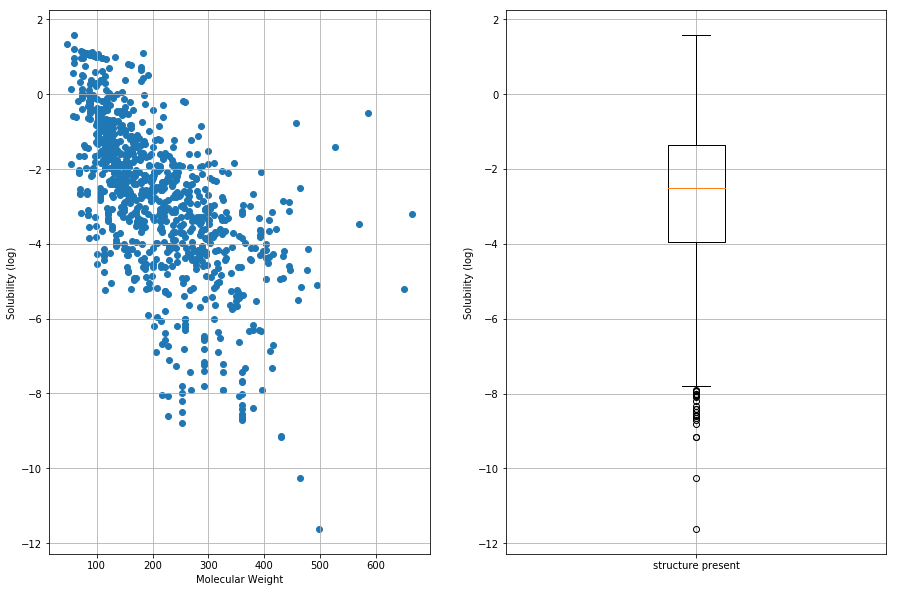

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(trainX['MolWeight'], trainY)
ax1.set_xlabel("Molecular Weight")
ax1.set_ylabel("Solubility (log)")

trainY_strPresent = trainY.loc[np.where(trainX['FP003'] == 1)[0]]
trainY_strAbsent = trainY.loc[np.where(trainX['FP003'] == 0)[0]]
trainY_str = pd.concat([trainY_strPresent, trainY_strAbsent], ignore_index=True)

ax2.boxplot(np.array(trainY_str))
ax2.set_xticklabels(['structure present', 'structure absent'])
ax2.set_ylabel("Solubility (log)")


It is useful to explore the training set to understand the characteristics of the data prior to modeling.

In [10]:
# evaluate the continuous predictors for skewness
trainX_c = trainX[trainX.columns[-20:]] # continuous predictors

from scipy.stats import skew
trainX_skewness = trainX_c.apply(skew)
print("Summary of skewness: range {0}; mean {1}".format((round(np.min(trainX_skewness), 2), 
                                                         round(np.max(trainX_skewness), 2)), 
                                                        round(np.mean(trainX_skewness), 2)))

Summary of skewness: range (0.67000000000000004, 3.8399999999999999); mean 1.65


It indicates that these predictors have a propensity to be right skewed (skewness = 0 if normally distributed). To correct for this skewness, a Box-Cox transformation was applied to all predictors (add a shift parameter to non-positive predictors).

#### Side note

One-parameter Box-Cox transformations (for x > 0)
\begin{equation}
x^* = \begin{cases} {x^{\lambda}-1 \over \lambda} & \text{if} \ \lambda \neq 0 \\ log(x) & \text{if} \ \lambda = 0 \end{cases}
\end{equation}

Two-parameter Box-Cox transformations (for x > $\lambda_2$)
\begin{equation}
x^* = \begin{cases} {(x+\lambda_2)^{\lambda_1}-1 \over \lambda_1} & \text{if} \ \lambda_1 \neq 0 \\ log(x+\lambda_2) & \text{if} \ \lambda_1 = 0 \end{cases}
\end{equation}

In [11]:
# Box-Cox transformed predictors
trainX_trans = pd.read_csv("../datasets/solubility/solTrainXtrans.csv").drop("Unnamed: 0", axis=1)
testX_trans = pd.read_csv("../datasets/solubility/solTestXtrans.csv").drop("Unnamed: 0", axis=1)

###### Q1: Is it safe to assume that the relationship between the predictors and outcome is linear?

In [12]:
trainX_trans_c = trainX_trans[trainX_trans.columns[-20:]] # 20 continuous predictors

# lowess (local smoother)
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

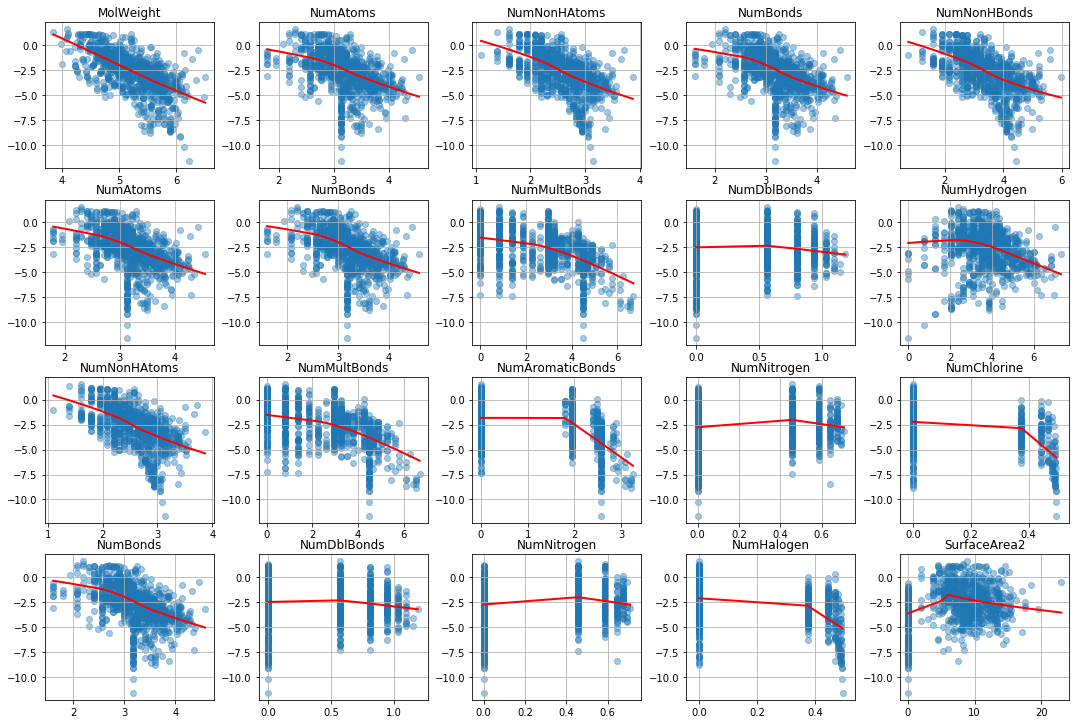

In [13]:
def plotContinuousPredictors(X, y, nrows=4, ncols=5):
    '''plot the continous predictors (default 20) versus the outcome'''
    fig, axarr = plt.subplots(nrows, ncols)
    fig.tight_layout()
    
    for r in range(nrows):
        for c in range(ncols):
            plotOnePredictor(axarr[r, c], X.iloc[:, (r+1)*(c+1)-1], y)
            
def plotOnePredictor(ax, X, y):
    '''plot one predictor versus the outcome'''
    z = lowess(np.squeeze(y), np.squeeze(X), 0.88) # return sorted X and y_fit
    ax.scatter(X, y, alpha=0.4)
    ax.plot(z[:, 0], z[:, 1], 'r', linewidth=2)
    ax.set_title(X.name)
    
    
plotContinuousPredictors(trainX_trans_c, trainY)

The smoothed regression lines indicate that there are some linear and non-linear relationship between the predictors and the outcome. Because of this, we might consider augmenting the predictor set with quadratic terms for some variables.

###### Q2: Are there significant between-predictor correlations?

Text(0,0.5,'Component')

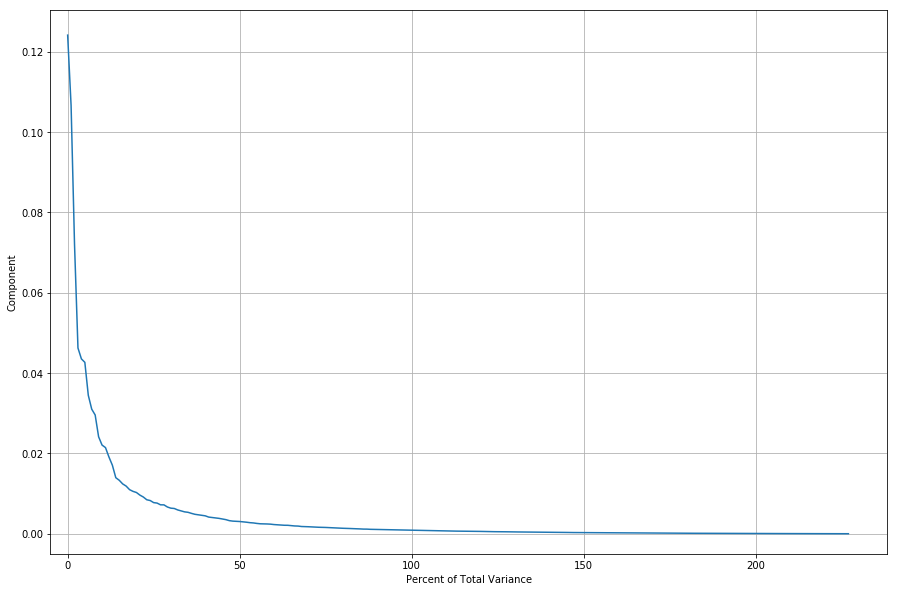

In [14]:
# PCA scree plot
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# scale before PCA
trainX_trans_scale = scale(trainX_trans)

pca = PCA()
pca.fit(trainX_trans_scale)

# generate scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlim((-5, None))
plt.ylim((-0.005, None))
plt.xlabel('Percent of Total Variance')
plt.ylabel('Component')

Notice that the amount of variability summarized by components drops sharply, with no one component accounting for more than 13% of the variance. This profile indicates that the structure of the data is contained in a much smaller number of dimensions than the number of dimensions of the original space; this is often due to a large number of collinearities among the predictors.

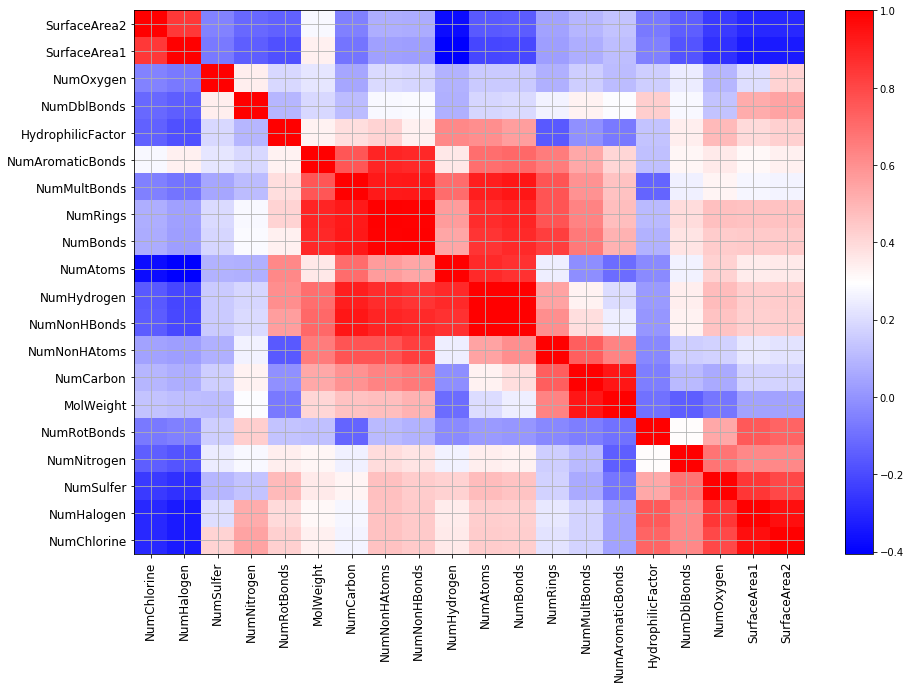

In [15]:
# correlation matrix for continuous predictors
corr_dataframe_c = trainX_trans_c.corr()

# compute hierarchical cluster on both rows and columns for correlation matrix and plot heatmap 
def corr_heatmap(corr_dataframe):
    import scipy.cluster.hierarchy as sch
    
    corr_matrix = np.array(corr_dataframe)
    col_names = corr_dataframe.columns
    
    Y = sch.linkage(corr_matrix, 'single', 'correlation')
    Z = sch.dendrogram(Y, color_threshold=0, no_plot=True)['leaves']
    corr_matrix = corr_matrix[Z, :]
    corr_matrix = corr_matrix[:, Z]
    col_names = col_names[Z]
    im = plt.imshow(corr_matrix, interpolation='nearest', aspect='auto', cmap='bwr')
    plt.colorbar()
    plt.xticks(range(corr_matrix.shape[0]), col_names, rotation='vertical', fontsize=12)
    plt.yticks(range(corr_matrix.shape[0]), col_names[::-1], fontsize=12)
    
# plot
corr_heatmap(corr_dataframe_c)

There are many strong positive correlations (dard red). As discussed in Chapter 3, this could create problems in developing some models and appropriate pre-processing steps will need to be taken to account for this problem.

## 6.2 Linear Regression

The objective of ordinary least square is find the plane that minimize the sum-of-squared errors (SSE) between the observed and predicted response: $$\text{SSE} = \sum_{i=1}^n (y_i - \hat{y}_i)^2,$$ where $y_i$ is the outcome and $\hat{y}_i$ is the model prediction of that sample's outcome. Mathematically, the optimal plane can be shown to be $$\hat{\beta} = (\pmb{X}^T \pmb{X})^{-1} \pmb{X}^T y,$$ where $\pmb{X}$ is the matrix of predictors, $y$ is the response vector, and $\hat{\beta}$ is the parameter estimates for each predictor. Making some assumptions about the distribution of the residuals, it is straightforward to show these estimates minimize the bias component of the bias-variance trade-off.

Notice that a unique inverse of $\pmb{X}^T \pmb{X}$ exists when (1) no predictor can be determined from a combination of one or more of the other predictors and (2) the number of samples is greater than the number of predictors. Note that linear regression can still be used for prediction when collinearity exists within the data. But we lose the ability to meaningfully interpret the coefficients. In practice, highly correlated predictors might be managed manually by removing one of the offending predictors. However, if the number of predictors is large, this may be difficult. Also, on many occasions, relationships among predictors can be complex and involve many predictors. In these cases, manual removal of specific predictors may not be possible and models that can tolerate collinearity may be more useful.

When condition (2) is true for a data set, we suggest using pre-processing techniques, such as removing pairwise correlated predictors and checking *variance inflation factor* (VIF). After pre-processing the data, if the number of predictors still outnumbers the number of observations, we need to consider PCA pre-processing, or simultaneous dimension reduction and regression via PLS or parameters shrinking estimates such as ridge regression, the lass or the elastic net.

Another drawback of multiple linear regression is that its solution is linear in the paramters. One visual clue to understanding if the relationship between predictors and the response is not linear is to examine the basic diagnostic plots. Curvature in the predicted-versus-residual plot is a primary indicator that the underlying relationship is not linear. Easily identifiable quadratic, cubic, or interactions between predictors can be accommodated in regression by add quadratic, cubic, and interactions of the original predictors.

A third notable problem with multiple linear regression is that it is prone to chasing observations that are away from the overall trend of the majority of the data. Observations that cause significant changes in the parameter estimates are called *influential*. One common approach to address these problems is to use an alternative metric to SSE that is less sensitive to large outliers, such as absolute errors and Huber function.

There are no tuning parameters for multiple linear regression. This fact, however, dose not impugn the practitioner from using rigorous model validation tools. In fact, we must use the same training and validation techniques to understand the predictive ability of this model on data which the model has not seen.

### Linear Regression for Solubility Data

Recall that we split the solubility data into training and test sets and applied a Box-Cox transformation to the continuous predictors in order to remove skewness. The next step is to identify predictors that have high pairwise correlations and to remove predictors so that no absolute pairwise correlation is greater than some pre-specified level.

In this case, we remove predictors that have pairwise correlations greater than 0.9 using a heuristic approach introduced in Chapter 3.

In [69]:
corr_dataframe = trainX_trans.corr()

def remove_high_corr(corr_dataframe, thresh = 0.9):
    '''remove predictors with high pairwise correlation'''
    abs_corr = np.abs(corr_dataframe).as_matrix() # absolute correlation matrix
    col_names = list(corr_dataframe.columns)
    
    # set up diagonal to 0
    np.fill_diagonal(abs_corr, 0)
    
    print "Removed predictors (in order): \n"
    while np.max(abs_corr) >= thresh:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape) # find maximum element
        # print abs_corr[i, j]
        rdx = which_to_remove(i, j, abs_corr)
        # remove corresponding predictor
        print col_names.pop(rdx)
        abs_corr = np.delete(abs_corr, rdx, 0)
        abs_corr = np.delete(abs_corr, rdx, 1)
        
    return col_names

def which_to_remove(i, j, abs_corr):
    '''compare two predictors and remove the one with higher abs correlation with other predictors'''
    i_absmean = np.mean(abs_corr[i, np.where(abs_corr[i,:] == 0)])
    j_absmean = np.mean(abs_corr[j, np.where(abs_corr[j,:] == 0)])
    
    return i if i_absmean > j_absmean else j

# remained predictors
col_remained = remove_high_corr(corr_dataframe)
trainX_trans_filtered = trainX_trans[col_remained]
testX_trans_filtered = testX_trans[col_remained]

Removed predictors (in order): 

NumBonds
NumSulfer
FP203
FP208
NumNonHBonds
NumChlorine
NumHalogen
FP183
FP014
FP194
NumNitrogen
NumAromaticBonds
FP033
FP166
FP163
FP180
SurfaceArea2
FP024
FP175
FP167
FP141
FP144
FP155
FP052
FP056
FP110
NumCarbon
FP005
FP179
FP136
FP162
FP087
FP092
FP112
FP067
FP051


Upon removing these predictors, a linear model was fit to the training data. The linear model was resampled using 10-fold cross-validation and the estimated RMSE and $\text{R}^2$ is reported.

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, ShuffleSplit

cv = ShuffleSplit(trainX_trans_filtered.shape[0], n_iter=10, random_state=0)

lm = LinearRegression()
train_scores_mse = cross_val_score(lm, trainX_trans_filtered, trainY.values, cv=cv, 
                                   scoring = 'mean_squared_error')
train_scores_rmse = np.sqrt(-1.0 * train_scores_mse)

train_scores_r2 = cross_val_score(lm, trainX_trans_filtered, trainY.values, cv=cv, 
                                  scoring = 'r2')
print "CV estimated RMSE: {0} \nCV estimated R2: {1}".format(np.mean(train_scores_rmse), np.mean(train_scores_r2))

CV estimated RMSE: 0.707044315368 
CV estimated R2: 0.874723530558


In [71]:
# apply to the test set
lm.fit(trainX_trans_filtered, trainY.values)
testY_pred = lm.predict(testX_trans_filtered)

from sklearn.metrics import r2_score, mean_squared_error
test_score_r2 = r2_score(testY.values, testY_pred)
test_score_rmse = np.sqrt(mean_squared_error(testY.values, testY_pred))

print "Test set RMSE: {0} \nTest set R2: {1}".format(test_score_rmse, test_score_r2)

Test set RMSE: 0.742917835704 
Test set R2: 0.871834926473


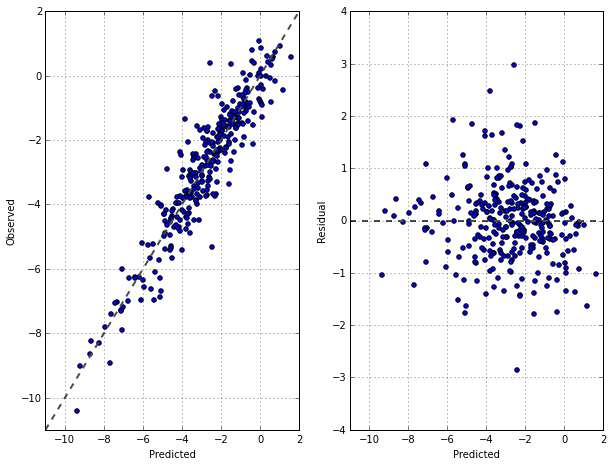

In [72]:
# regression diagnostic
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(testY_pred, testY.values)
ax1.set(xlim=(-11, 2), ylim=(-11, 2))
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3", linewidth=2)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Observed")

ax2.scatter(testY_pred, testY.values-testY_pred)
ax2.set(xlim=(-11, 2))
ax2.plot(ax1.get_xlim(), (0, 0), ls="--", c=".3", linewidth=2)
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Residual")

There does not appear to be any bias in the prediction, and the distribution between the predicted values and residuals appears to be random about zero.

## 6.3 Partial Least Squares

If the correlation among predictors is high, then the ordinary least squares solution for multiple linear regression will have high variability and will become unstable. One the other hand, if the number of predictors may be greater than the number of observations, ordinary least squares in its usual form will be unable to find a unique set of regression coefficients that minimize the SSE.

A couple of common solutions include pre-processing the predictor by either (1) removal of the highly correlated predictors or (2) conducting PCA on the predictors. Removing highly correlated predictors ensures that pairwise correlations among predictors are below a pre-specified threshold. However, this process does not necessarily ensure that linear combinations of predictors are uncorrelated with each other, i.e., it may not guarantee a stable least squares solution. Alternatively, using PCA for pre-processing guarantees that the resulting predictors, or combinations thereof, will be uncorrelated. The trade-off in using PCA is that the new predictors are linear combinations of the original predictors, and thus, the practical understanding of the new predictors can become murky.

Pre-processing predictors via PCA prior to performing regression is known as principal component regression (PCR). While this two-step regression approach (dimension reduction, then regression) has been widely applied to problems with inherently highly correlated predictors or problems with more predictors than observations, it can easily be misled. Specifically, dimension reduction via PCA does not necessarily produce new predictors that explain the response, since PCA does not consider any aspects of the response when it selects its components. Instead, it simply chases the variability present throughout the predictor space. Because of this inherent problem with PCR, we recommend using PLS when there are correlated predictors and a linear regression-type solution is desired.

PLS find linear combinations of the predictors just like PCA. While the PCA linear combinations are chosen to maximally summarize predictor space variability, the PLS linear combinations of predictors are chosen to maximally summarize covariance with the response. This means that PLS finds components that maximally summarize the variation of the predictors while simultaneously requiring these components to have maximum correlation with the response. It strikes a compromise between the objectives of predictor space dimension reduction and a predictive relationship with the reponse. In other words, PLS is a *supervised* dimension reduction procedure; PCR is an *unsupervised* procedure.

Prior to performing PLS, the predictors should be centered and scaled, especially if the predictors are on scale of differing magnitude. The PLS has one tuning parameter: the number of components to retain. Resampling techniques can be used to determine the optimal number of components.

### PCR and PLSR for Solubility Data

Return to our previous example, 10-fold cross-validation was used to determine the optimal number of components to retain that minimize RMSE in both PCR and PLSR.

In [73]:
# RMSEs for 50 components were examined
pcr_rmse = np.zeros([50, 2])
plsr_rmse = np.zeros([50, 2])

# 10-fold CV
cv = ShuffleSplit(trainX_trans.shape[0], n_iter=10)

In [74]:
def optimal_with_osr(rmse):
    '''Return the minimum RMSE and its # of components using "one-standard error" rule'''
    n_best = np.argmin(rmse[:, 0])
    rmse_min = rmse[n_best, 0] + rmse[n_best, 1]
    n_best = np.min(np.where(rmse[:, 0] <= rmse_min))
    return (n_best+1), rmse_min

In [75]:
# PCR
from sklearn.decomposition import PCA

for n_compo in range(len(pcr_rmse)):
    pca = PCA(n_components= n_compo+1)
    pca_compo = pca.fit_transform(trainX_trans_scale)
    train_scores_mse = cross_val_score(LinearRegression(), pca_compo, trainY.values, cv=cv, scoring = 'mean_squared_error')
    pcr_rmse[n_compo, 0] = np.mean(np.sqrt(-1.0 * train_scores_mse))
    pcr_rmse[n_compo, 1] = np.std(np.sqrt(-1.0 * train_scores_mse))

n_best, rmse_min = optimal_with_osr(pcr_rmse)
print "With one-standard error rule, the minimum PCR RMSE is {0} with {1} components".format(rmse_min, n_best)

With one-standard error rule, the minimum PCR RMSE is 0.860014338691 with 43 components


In [76]:
# PLSR
from sklearn.cross_decomposition import PLSRegression

for n_compo in range(len(plsr_rmse)):
    plsr= PLSRegression(n_components= n_compo+1, scale=False)
    train_scores_mse = cross_val_score(plsr, trainX_trans_scale, trainY.values, cv=cv, scoring = 'mean_squared_error')
    plsr_rmse[n_compo, 0] = np.mean(np.sqrt(-1.0 * train_scores_mse))
    plsr_rmse[n_compo, 1] = np.std(np.sqrt(-1.0 * train_scores_mse))

n_best, rmse_min = optimal_with_osr(plsr_rmse)
print "With one-standard error rule, the minimum PLSR RMSE is {0} with {1} components".format(rmse_min, n_best)

With one-standard error rule, the minimum PLSR RMSE is 0.726648755663 with 12 components


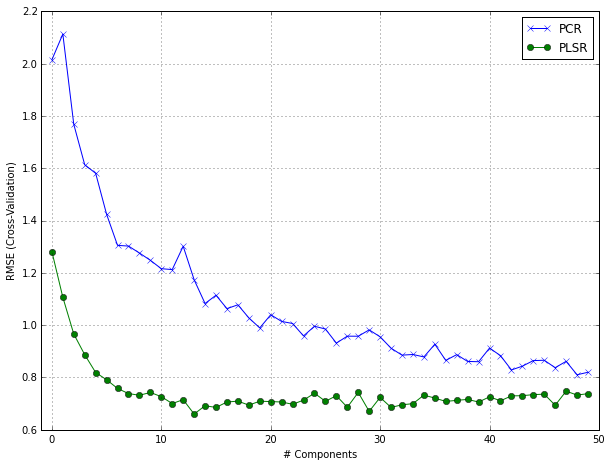

In [77]:
plt_pcr, = plt.plot(pcr_rmse[:,0], '-x')
plt_plsr, = plt.plot(plsr_rmse[:,0], '-o')
plt.xlim((-1, None))
plt.xlabel("# Components")
plt.ylabel("RMSE (Cross-Validation)")
plt.legend([plt_pcr, plt_plsr], ['PCR', 'PLSR'])

With these data, we see the supervised dimension reduction finds a minimum RMSE with significantly fewer components than unsupervised dimension reduction.

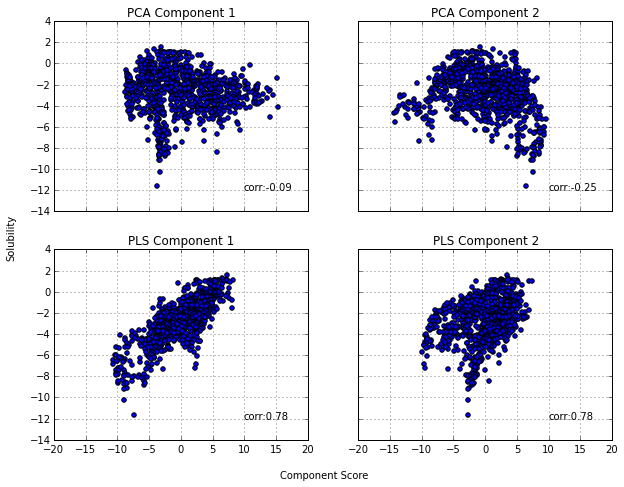

In [78]:
from scipy.stats import pearsonr

# compoare the first two components
pca2 = PCA(n_components=2)
pca2.fit(trainX_trans_scale)

plsr2 = PLSRegression(n_components=2, scale=False)
plsr2.fit(trainX_trans_scale, trainY.values)

# visulization
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
#fig.tight_layout()

axarr[0,0].scatter(pca2.transform(trainX_trans_scale)[:, 0], trainY.values)
axarr[0,0].set_title("PCA Component 1")
corr = pearsonr(pca2.transform(trainX_trans_scale)[:, 0], trainY.values[:,0])[0]
axarr[0,0].text(10, -12, 'corr:' + str(round(corr, 2)))

axarr[0,1].scatter(pca2.transform(trainX_trans_scale)[:, 1], trainY.values)
axarr[0,1].set_title("PCA Component 2")
corr = pearsonr(pca2.transform(trainX_trans_scale)[:, 1], trainY.values[:,0])[0]
axarr[0,1].text(10, -12, 'corr:' + str(round(corr, 2)))

axarr[1,0].scatter(plsr2.transform(trainX_trans_scale)[:, 0], trainY.values)
axarr[1,0].set_title("PLS Component 1")
corr = pearsonr(plsr2.transform(trainX_trans_scale)[:, 0], trainY.values[:,0])[0]
axarr[1,0].text(10, -12, 'corr:' + str(round(corr, 2)))

axarr[1,1].scatter(plsr2.transform(trainX_trans_scale)[:, 1], trainY.values)
axarr[1,1].set_title("PLS Component 2")
corr = pearsonr(plsr2.transform(trainX_trans_scale)[:, 0], trainY.values[:,0])[0]
axarr[1,1].text(10, -12, 'corr:' + str(round(corr, 2)))

fig.text(0.5, 0.06, 'Component Score', ha='center', va='center')
fig.text(0.06, 0.5, 'Solubility', va='center', rotation='vertical')

It is not surprising that the correlation between these components and the response is greater for PLS than PCR.

Prediction of the test set using the optimal PCR and PLS models is compared.

In [79]:
from sklearn.preprocessing import scale
testX_trans_scale = scale(testX_trans)

# PCR
pca = PCA(n_components=34) # optimal
pca.fit(trainX_trans_scale)
trainX_pca = pca.transform(trainX_trans_scale)
testX_pca = pca.transform(testX_trans_scale)
lm = LinearRegression()
lm.fit(trainX_pca, trainY.values)
testY_pca_pred = lm.predict(testX_pca)

# PLSR
plsr = PLSRegression(n_components=7, scale=False)
plsr.fit(trainX_trans_scale, trainY.values)
testY_plsr_pred = plsr.predict(testX_trans_scale)

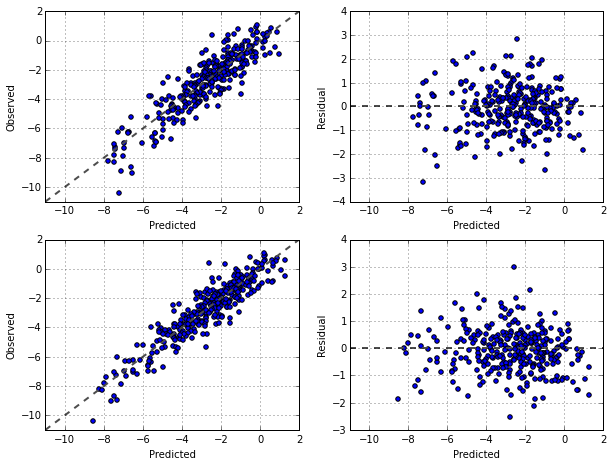

In [80]:
# regression diagnostic
fig, axarr = plt.subplots(2, 2)

axarr[0, 0].scatter(testY_pca_pred, testY)
axarr[0, 0].set(xlim=(-11, 2), ylim=(-11, 2))
axarr[0, 0].plot(axarr[0,0].get_xlim(), axarr[0,0].get_ylim(), ls="--", c=".3", linewidth=2)
axarr[0, 0].set_xlabel("Predicted")
axarr[0, 0].set_ylabel("Observed")

axarr[0, 1].scatter(testY_pca_pred, testY-testY_pca_pred)
axarr[0, 1].set(xlim=(-11, 2))
axarr[0, 1].plot(axarr[0,1].get_xlim(), (0,0), ls="--", c=".3", linewidth=2)
axarr[0, 1].set_xlabel("Predicted")
axarr[0, 1].set_ylabel("Residual")

axarr[1, 0].scatter(testY_plsr_pred, testY)
axarr[1, 0].set(xlim=(-11, 2), ylim=(-11, 2))
axarr[1, 0].plot(axarr[0,0].get_xlim(), axarr[1,0].get_ylim(), ls="--", c=".3", linewidth=2)
axarr[1, 0].set_xlabel("Predicted")
axarr[1, 0].set_ylabel("Observed")

axarr[1, 1].scatter(testY_plsr_pred, testY-testY_plsr_pred)
axarr[1, 1].set(xlim=(-11, 2))
axarr[1, 1].plot(axarr[1,1].get_xlim(), (0,0), ls="--", c=".3", linewidth=2)
axarr[1, 1].set_xlabel("Predicted")
axarr[1, 1].set_ylabel("Residual")

The predictive ability of each method is good, and the residuals appear to be randomly scattered about zero. Although the predictive ability of these models is close, PLS finds a simpler model that uses far fewer components than PCR.

## 6.4 Penalized Models

Under standard assumptions, the coefficients produced by ordinary least squares regression are unbiased and, of all unbiased linear techniques, this model also has the lowest variance. However, given that the MSE is a combination of variane and bias, it is very possible to produce models with smaller MSEs by allowing the parameter estimates to be biased. Combatting collinearity by using biased models may result in regression models where the overall MSE is competitive.

One method of creating biased regression models is to add a penalty to the sum of the squared errors. Recall that original least squares regression found parameter estimates to minimize the sum of the squared errors: $$\text{SSE} = \sum_{i=1}^n (y_i - \hat{y}_i)^2.$$ When the model over-fits the data, or when there are issues with collinearity, the linear regression parameter estimates may become inflated. Controlling (or *regularizing*) the parameter estimates can be accomplished by adding a penalty to the SSE if the estimates become large.

*Ridge regression* adds a second-order penalty on the SSE: $$\text{SSE}_{L_2} = \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^P \beta_j^2.$$ In effect, this method *shrinks* the estimates towards 0 as the $\lambda$ penalty become large.

By adding the penalty, we are making a trade-off between the model variance and bias. By sacrificing some bias, we can often reduce the variance enough to make the overall MSE lower than unbiased models.

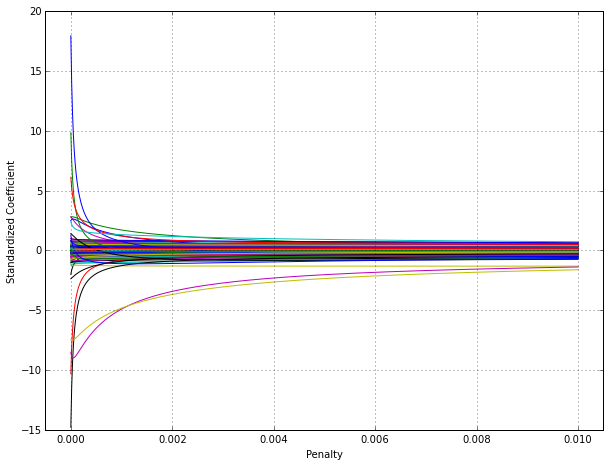

In [81]:
# path of the ridge regression coefficients
from sklearn.linear_model import Ridge

lambda_range = np.linspace(0.0, 0.01, 600)
ridgeModel = Ridge(normalize=True)
coeff_path = []

for a in lambda_range:
    ridgeModel.set_params(alpha = a)
    ridgeModel.fit(trainX_trans, trainY)
    coeff_path.append(ridgeModel.coef_[0])

ax = plt.gca()
ax.plot(lambda_range, coeff_path)
ax.set_xlim((-0.0005, 0.0105))
plt.xlabel("Penalty")
plt.ylabel("Standardized Coefficient")

When there is no penalty, many parameters have reasonable values, but some parameter estimates are abnormally large. These large values are indicative of collinearity issues. As the penalty is increased, the paramter estimates move closer to 0 at diferent rate.

Use cross-validation, the penalty value was optimized (over-fit -> under-fit).

(-0.005, 0.105)

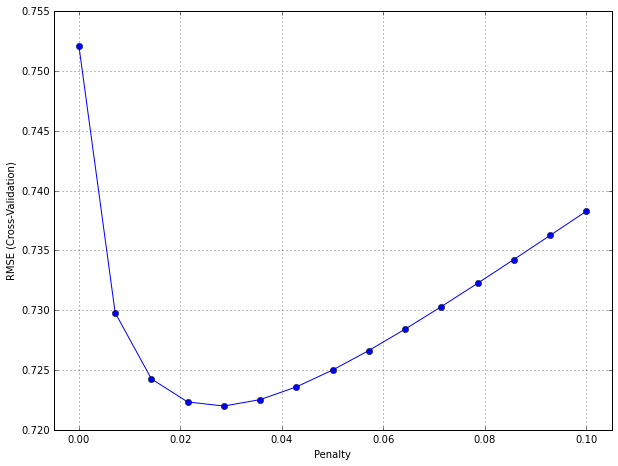

In [82]:
# penalty value versus RMSE
lambda_range = np.linspace(0.0, 0.1, 15)
score_rmse = np.zeros(15)

ridgeModel = Ridge(normalize=True)

for adx, a in enumerate(lambda_range):
    temp_scores = cross_val_score(ridgeModel.set_params(alpha = a),
                                  trainX_trans, trainY.values,
                                  cv=10, scoring="mean_squared_error")
    temp_scores = np.sqrt(-1.0 * temp_scores)
    score_rmse[adx] = np.mean(temp_scores)
    
plt.plot(lambda_range, score_rmse, '-o')
plt.xlabel("Penalty")
plt.ylabel("RMSE (Cross-Validation)")
plt.xlim((-0.005, 0.105))

While ridge regression shrinks the parameter estimates towards 0, the model does not set the values to absolute 0 for any value of the penalty. Even though some parameter estimates become negligibly small, this model does not conduct *feature selection*.

A popular alternative to ridge regression is the *least absolute shrinkage and selection operator* model, known as the *lasso*. It uses a similar penalty to ridge regression $$\text{SSE}_{L_1} = \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^P |\beta_j|.$$ While this may seem like a small modification, the practical implications are significant. While the regression coefficients are still shrunk towards 0, a consequence of penalizing the absolute values is that some parametes are actually set to 0 for some values of $\lambda$. Thus the lasso yields models that simultaneously use regularization to improve the model and to conduct feature selection.

.

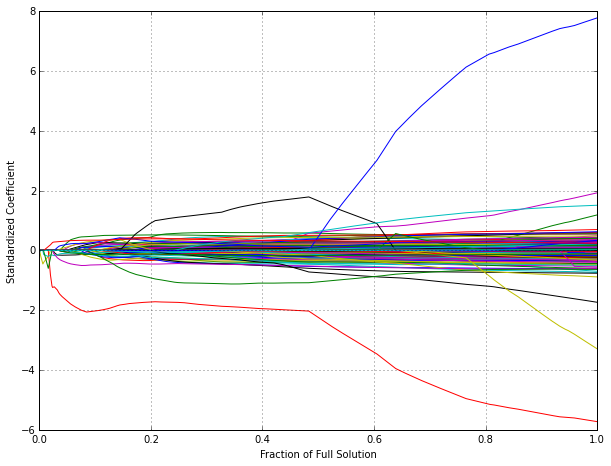

In [83]:
# path of the lasso regression coefficients
from sklearn.linear_model import lars_path

# compute regularization path using the LARS
lambdas, _, coefs = lars_path(trainX_trans.values, trainY.values[:,0], method = 'lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
plt.xlabel('Fraction of Full Solution')
plt.ylabel('Standardized Coefficient')

The x-axis is the fraction of the full solution (i.e., ordinary least squares with no penalty). Smaller values on the x-axis indicate that a large penalty has been used. When the penalty is large, many of the regression coefficients are set to 0.

A significant advancement for this model, the least angle regression (LARS), is a broad framework that encompassess the lasso and similar models. The LARS model can be used to fit lasso models more efficiently, especially in high-dimensional problems.

A generalization of the lasso model is the *elastic net*. The model combines te two types of penalties: $$\text{SSE}_{Enet} = \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda_1 \sum_{j=1}^P |\beta_j| + \lambda_2 \sum_{j=1}^P \beta_j^2.$$ The advantage of this model is that it enables effective regularization via the ridge-type penalty with the feature selection quality of the lasso penalty. Both the penalties require tuning to achieve optimal performance.